# Week7_복습과제_우정연


# Beginner Friendly CATBOOST with OPTUNA

In [ ]:
!pip install optuna

In [ ]:
!pip install catboost
!pip install "dask[dataframe]"

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold,cross_val_score, RepeatedStratifiedKFold,StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import OneHotEncoder,StandardScaler,PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier

import optuna
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer

from sklearn.model_selection import KFold, cross_val_predict, train_test_split,GridSearchCV,cross_val_score
from sklearn.metrics import accuracy_score,classification_report

#importing plotly and cufflinks in offline mode
import cufflinks as cf
cf.go_offline(connected=True)
cf.set_config_file(offline=True, world_readable=True)

import plotly
import plotly.express as px
import plotly.graph_objs as go
import plotly.io as pio
pio.renderers.default = "colab"

from plotly.offline import iplot
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

import missingno as msno

import warnings
warnings.filterwarnings("ignore")

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 900)

pd.set_option('display.max_colwidth', 200)

df = pd.read_csv('drive/My Drive/Colab Notebooks/heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [ ]:
df.duplicated().sum()

0

In [ ]:
def missing (df):
    missing_number = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return missing_values

missing(df)
#missing value 찾기

,Missing_Number,Missing_Percent
Age,0,0.0
Sex,0,0.0
ChestPainType,0,0.0
RestingBP,0,0.0
Cholesterol,0,0.0
FastingBS,0,0.0
RestingECG,0,0.0
MaxHR,0,0.0
ExerciseAngina,0,0.0
Oldpeak,0,0.0


In [ ]:
numerical = df.drop(['HeartDisease'], axis = 1).select_dtypes('number').columns

categorical = df.select_dtypes('object').columns

print(f'Numerical Columns:  {df[numerical].columns}')
print('\n')
print(f'Categorical Columns: {df[categorical].columns}')

Numerical Columns:  Index(['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak'], dtype='object')


Categorical Columns: Index(['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], dtype='object')


In [ ]:
# extremely high variance 또는 zero variance 가 없음
df[categorical].nunique()

,0
Sex,2
ChestPainType,4
RestingECG,3
ExerciseAngina,2
ST_Slope,3


In [ ]:
y = df['HeartDisease']
print(f'Percentage of patient had a HeartDisease:   {round(y.value_counts(normalize=True)[1]*100,2)} % --> ({y.value_counts()[1]} patient)\nPercentage of patient did not have a HeartDisease: {round(y.value_counts(normalize=True)[0]*100,2)} % --> ({y.value_counts()[0]} patient)')


Percentage of patient had a HeartDisease:   55.34 % --> (508 patient)
Percentage of patient did not have a HeartDisease: 44.66 % --> (410 patient)


In [ ]:
df['HeartDisease'].iplot(kind='hist')

In [ ]:
df[numerical].describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000


In [ ]:
df[numerical].iplot(kind='hist');

In [ ]:
df[numerical].iplot(kind='histogram', subplots=True, bins=50)

In [ ]:
# threshold-limit to evaluate skewness
skew_limit = 0.75
skew_vals = df[numerical].drop('FastingBS', axis = 1).skew()
skew_cols = skew_vals[abs(skew_vals)> skew_limit].sort_values(ascending=False)
skew_cols

,0
Oldpeak,1.022872


Oldpeak feature 만 skewness 0.75 이상임

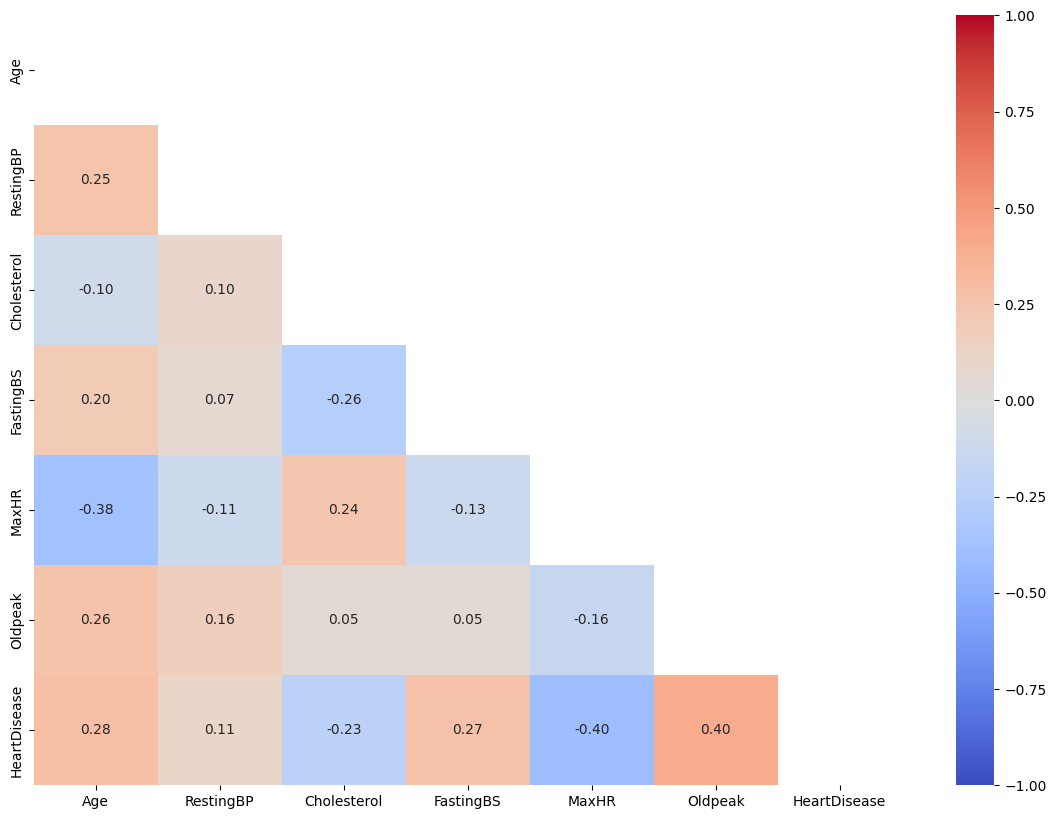

In [ ]:
numerical1 = df.select_dtypes('number').columns

matrix = np.triu(df[numerical1].corr())
fig, ax = plt.subplots(figsize = (14,10))
sns.heatmap(df[numerical1].corr(), annot=True, fmt='.2f', vmin=-1, vmax=1, center=0, cmap='coolwarm',mask=matrix, ax=ax);

1: 완벽한 양의 상관관계/
-1: 완벽한 음의 상관관계

In [ ]:
df[categorical].head()

,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
0,M,ATA,Normal,N,Up
1,F,NAP,Normal,N,Flat
2,M,ATA,ST,N,Up
3,F,ASY,Normal,Y,Flat
4,M,NAP,Normal,N,Up


[Gender and HeartDisease]

In [ ]:
print(f'A female person has a probability of {round(df[df["Sex"]=="F"]["HeartDisease"].mean()*100,2)}% have a HeartDisease')

print()

print(f'A male person has a probability of {round(df[df["Sex"]=="M"]["HeartDisease"].mean()*100,2)} % have a HeartDisease')

print()

A female person has a probability of 25.91% have a HeartDisease

A male person has a probability of 63.17 % have a HeartDisease



In [ ]:
fig = px.histogram(df, x="Sex", color = "HeartDisease", width = 400, height = 400)
fig.show()

[Chest Pain Type and Heart Disease]

In [ ]:
df.groupby('ChestPainType')['HeartDisease'].mean().sort_values(ascending=False)

,HeartDisease
ChestPainType,
ASY,0.790323
TA,0.434783
NAP,0.354680
ATA,0.138728


In [ ]:
fig = px.histogram(df, x="ChestPainType", color ="HeartDisease", width = 400, height=400)
fig.show()

[RestingECG and Heart Disease]

In [ ]:
df.groupby('RestingECG')['HeartDisease'].mean().sort_values(ascending=False)

,HeartDisease
RestingECG,
ST,0.657303
LVH,0.563830
Normal,0.516304


In [ ]:
fig = px.histogram(df, x = "RestingECG", color = "HeartDisease", width=400, height=400)
fig.show()

[ExerciseAngina and Heart Disease]

In [ ]:
df.groupby('ExerciseAngina')['HeartDisease'].mean().sort_values(ascending=False)

,HeartDisease
ExerciseAngina,
Y,0.851752
N,0.351005


In [ ]:
fig = px.histogram(df, x="ExerciseAngina", color="HeartDisease", width=400, height=400)
fig.show()

[ST_Slope and Heart Disease]

In [ ]:
df.groupby('ST_Slope')['HeartDisease'].mean().sort_values(ascending=False)

,HeartDisease
ST_Slope,
Flat,0.828261
Down,0.777778
Up,0.197468


#Model_Selection

[Baseline Model]

In [ ]:
accuracy=[]
model_names=[]

X = df.drop('HeartDisease', axis = 1)
y = df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

ohe = OneHotEncoder()
ct = make_column_transformer((ohe,categorical), remainder='passthrough')

model = DummyClassifier(strategy='constant', constant=1)
pipe = make_pipeline(ct, model)
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
accuracy.append(round(accuracy_score(y_test, y_pred),4))
print(f'model : {model} and accuracy score is : {round(accuracy_score(y_test, y_pred),4)}')

model_names = ['DummyClassifier']
dummy_result_df = pd.DataFrame({'Accuracy':accuracy}, index = model_names)
dummy_result_df

model : DummyClassifier(constant=1, strategy='constant') and accuracy score is : 0.5942


,Accuracy
DummyClassifier,0.5942


[Logistic & Linear Discriminant & SVC & KNN]

In [ ]:
accuracy = []
model_name = []

X = df.drop('HeartDisease', axis = 1)
y = df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

ohe = OneHotEncoder()
ct = make_column_transformer((ohe, categorical), remainder='passthrough')

lr = LogisticRegression(solver='liblinear')
lda = LinearDiscriminantAnalysis()
svm = SVC(gamma='scale')
knn = KNeighborsClassifier()

models = [lr, lda, svm, knn]

for model in models:
  pipe = make_pipeline(ct, model)
  pipe.fit(X_train, y_train)
  y_pred = pipe.predict(X_test)
  accuracy.append(round(accuracy_score(y_test, y_pred),4))
  print(f'model : {model} and accuracy score is : {round(accuracy_score(y_test, y_pred),4)}')

model_names = ['Logistic', 'LinearDiscriminant', 'SVM', 'KNeighbors']
result_df1 = pd.DataFrame({'Accuracy': accuracy}, index=model_names)
result_df1

model : LogisticRegression(solver='liblinear') and accuracy score is : 0.8841
model : LinearDiscriminantAnalysis() and accuracy score is : 0.8696
model : SVC() and accuracy score is : 0.7246
model : KNeighborsClassifier() and accuracy score is : 0.7174


,Accuracy
Logistic,0.8841
LinearDiscriminant,0.8696
SVM,0.7246
KNeighbors,0.7174


[Logistic & Linear Discriminant & SVC & KNN with Scaler]

In [ ]:
accuracy = []
model_names = []

X = df.drop('HeartDisease', axis = 1)
y = df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

ohe = OneHotEncoder()
s = StandardScaler()
ct1 = make_column_transformer((ohe,categorical),(s,numerical))

lr = LogisticRegression(solver = 'liblinear')
ida = LinearDiscriminantAnalysis()
svm = SVC(gamma='scale')
knn = KNeighborsClassifier()

models = [lr, lda, svm, knn]

for model in models:
  pipe = make_pipeline(ct1, model)
  pipe.fit(X_train, y_train)
  y_pred = pipe.predict(X_test)
  accuracy.append(round(accuracy_score(y_test, y_pred), 4))
  print(f'model : {model} and accuracy score is : {round(accuracy_score(y_test, y_pred),4)}')

model_names = ['Logistic_scl', 'LinearDiscriminant_scl', 'SVM_scl', 'KNeighbors_scl']
result_df2 = pd.DataFrame({'Accuracy':accuracy}, index=model_names)
result_df2

model : LogisticRegression(solver='liblinear') and accuracy score is : 0.8804
model : LinearDiscriminantAnalysis() and accuracy score is : 0.8696
model : SVC() and accuracy score is : 0.8841
model : KNeighborsClassifier() and accuracy score is : 0.8841


,Accuracy
Logistic_scl,0.8804
LinearDiscriminant_scl,0.8696
SVM_scl,0.8841
KNeighbors_scl,0.8841


표준화(mean=0, standard deviation=1)한 SVM, KNeighbors의 경우 성능이 향상됨

[Ensemble Models(AdaBoost & Gradient Boosting & Random Forest & Extra Tress)]

In [ ]:
accuracy = []
model_names = []

X = df.drop('HeartDisease', axis = 1)
y = df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

ohe = OneHotEncoder()
ct = make_column_transformer((ohe,categorical), remainder='passthrough')

ada = AdaBoostClassifier(random_state = 0)
gb = GradientBoostingClassifier(random_state = 0)
rf = RandomForestClassifier(random_state = 0)
et = ExtraTreesClassifier(random_state = 0)


models = [ada,gb,rf,et]

for model in models:
  pipe = make_pipeline(ct,model)
  pipe.fit(X_train, y_train)
  y_pred = pipe.predict(X_test)
  accuracy.append(round(accuracy_score(y_test, y_pred),4))
  print(f'model : {model} and accuracy score is : {round(accuracy_score(y_test, y_pred),4)}')

model_names = ['Ada', 'Gradient', 'Random', 'ExtraTree']
result_df3 = pd.DataFrame({'Accuracy':accuracy}, index=model_names)
result_df3

model : AdaBoostClassifier(random_state=0) and accuracy score is : 0.8659
model : GradientBoostingClassifier(random_state=0) and accuracy score is : 0.8768
model : RandomForestClassifier(random_state=0) and accuracy score is : 0.8877
model : ExtraTreesClassifier(random_state=0) and accuracy score is : 0.8804


,Accuracy
Ada,0.8659
Gradient,0.8768
Random,0.8877
ExtraTree,0.8804


[Famous Trio {XGBoost & LightGBM & Catboost}]

In [ ]:
accuracy = []
model_names = []

X = df.drop('HeartDisease', axis = 1)
y = df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

ohe = OneHotEncoder()
ct = make_column_transformer((ohe, categorical),remainder='passthrough')

xgbc = XGBClassifier(random_state = 0)
lgbmc = LGBMClassifier(random_state = 0)

models = [xgbc, lgbmc]

for model in models:
  pipe = make_pipeline(ct,model)
  pipe.fit(X_train, y_train)
  y_pred = pipe.predict(X_test)
  accuracy.append(round(accuracy_score(y_test, y_pred),4))

model_names = ['XGBoost', 'LightGBM']
result_df4 = pd.DataFrame({'Accuracy':accuracy}, index=model_names)
result_df4

[LightGBM] [Info] Number of positive: 344, number of negative: 298
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000605 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 354
[LightGBM] [Info] Number of data points in the train set: 642, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.535826 -> initscore=0.143548
[LightGBM] [Info] Start training from score 0.143548
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

,Accuracy
XGBoost,0.8478
LightGBM,0.8732


[CATBOOST]

  - 범주형 변수 자동 처리
    - 원핫인코딩이나 라벨인코딩 같은 전처리 없이 범주형 변수를 자동으로 처리
    - 범주형 변수의 조합도 자동으로 생성하여 활용
  - 과적합 방지 기능
    - ordered boosting 사용
    - 학습 데이터의 순서를 무작위로 변경하며 학습
    - 자체적인 과적합 방지 매커니즘 보유
  - 빠른 학습과 예측 속도
    - GPU 학습지원
    - 병렬 처리 지원
  - 이진 분류 문제 -> Logloss 자동 사용
  - 다중 분류 문제 -> MultiClass 자동 사용
  - CatBoost는 데이터의 특성을 파악하여 적저한 손실 함수를 자동으로 선택


In [ ]:
accuracy = []
model_names = []

X = df.drop('HeartDisease', axis = 1)
y = df['HeartDisease']
#float64 타입이 아닌 열들(즉,범주형 변수들)의 인덱스 찾기
categorical_features_indices = np.where(X.dtypes != np.float64)[0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

model = CatBoostClassifier(verbose = False, random_state = 0)

model.fit(X_train, y_train, cat_features = categorical_features_indices, eval_set = (X_test, y_test))
y_pred = model.predict(X_test)
accuracy.append(round(accuracy_score(y_test, y_pred),4))

model_names = ['Catboost_default']
result_df5 = pd.DataFrame({'Accuracy': accuracy}, index = model_names)
result_df5

,Accuracy
Catboost_default,0.8804


[CatBoost HyperParameter Tuning with Optuna]

- Bootstrap
  - 데이터를 resampling/ CatBoost-3가지 부트스트랩 제공
  - Baysian Bootstrap
    - 각 데이터 포인트에 가중치를 무작위로 할당
    - bagging_temperature 높을수록 가중치 차이가 커짐
    - 적합한 경우: 데이터셋 작을 때/ 노이즈 많은 데이터 처리 시
    - 장점: 더 다양한 모델 생성 가능/ 과적합 감소
  - Bernoulli Bootstrap
    - 각 데이터 포인트를 지정된 확률(subsample)로 선택
    - 적합한 경우: 대규모 데이터셋/ 메모리 제한 있을 때
    - 장점: 메모리 효율적/ 학습 속도 빠름
  - MVS(Minimal Variance Sampling)
    - 분산을 최소화하는 방식으로 샘플링
    - 추가 파라미터 필요 없음
    - 적합한 경우: 기본값으로 사용하기 좋은/ 안정적 결과 필요 시
    - 장점: 안정적인 결과/ 자동 최적화

In [ ]:
def objective(trial):
    X= df.drop('HeartDisease', axis=1)
    y= df['HeartDisease']
    categorical_features_indices = np.where(X.dtypes != np.float64)[0]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "3gb",
    }


    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    cat_cls = CatBoostClassifier(**param)
    cat_cls.fit(X_train, y_train, eval_set=[(X_test, y_test)], cat_features=categorical_features_indices,verbose=0, early_stopping_rounds=100)

    preds = cat_cls.predict(X_test)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(y_test, pred_labels)
    return accuracy


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=50, timeout=600)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))


[I 2024-11-10 13:46:45,365] A new study created in memory with name: no-name-484f6dea-5853-4ffe-8edb-5fe9365f719e
[I 2024-11-10 13:46:47,054] Trial 0 finished with value: 0.894927536231884 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.04454104963173135, 'depth': 5, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.894927536231884.
[I 2024-11-10 13:46:50,644] Trial 1 finished with value: 0.8913043478260869 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.0347098015311705, 'depth': 11, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.894927536231884.
[I 2024-11-10 13:47:07,297] Trial 2 finished with value: 0.8840579710144928 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.09812780420152478, 'depth': 12, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.5853592339965974}. Best is trial 0 with value: 0.894927536231884.
[I 2024-11-10 13:47

Number of finished trials: 50
Best trial:
  Value: 0.8985507246376812
  Params: 
    objective: Logloss
    colsample_bylevel: 0.044689144845833306
    depth: 10
    boosting_type: Plain
    bootstrap_type: MVS


In [ ]:
accuracy =[]
model_names =[]


X= df.drop('HeartDisease', axis=1)
y= df['HeartDisease']
categorical_features_indices = np.where(X.dtypes != np.float64)[0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = CatBoostClassifier(verbose=False,random_state=0,
                          objective= 'CrossEntropy',
                          colsample_bylevel= 0.04292240490294766,
                          depth= 10,
                          boosting_type= 'Plain',
                          bootstrap_type= 'MVS')

model.fit(X_train, y_train,cat_features=categorical_features_indices,eval_set=(X_test, y_test))
y_pred = model.predict(X_test)
accuracy.append(round(accuracy_score(y_test, y_pred),4))
print(classification_report(y_test, y_pred))

model_names = ['Catboost_tuned']
result_df6 = pd.DataFrame({'Accuracy':accuracy}, index=model_names)
result_df6

              precision    recall  f1-score   support

           0       0.88      0.90      0.89       112
           1       0.93      0.91      0.92       164

    accuracy                           0.91       276
   macro avg       0.90      0.91      0.91       276
weighted avg       0.91      0.91      0.91       276



,Accuracy
Catboost_tuned,0.9094


[Feature Importance]

In [ ]:
feature_importance = np.array(model.get_feature_importance())
features = np.array(X_train.columns)
fi={'features':features,'feature_importance':feature_importance}
df_fi = pd.DataFrame(fi)
df_fi.sort_values(by=['feature_importance'], ascending=True,inplace=True)
fig = px.bar(df_fi, x='feature_importance', y='features',title="CatBoost Feature Importance",height=500)
fig.show()

[Model Comparison]

In [ ]:
result_final = pd.concat([dummy_result_df,result_df1,result_df2,
                          result_df3,result_df4,result_df5,result_df6],axis=0)


In [ ]:
result_final.sort_values(by=['Accuracy'], ascending=True,inplace=True)
fig = px.bar(result_final, x='Accuracy', y=result_final.index,title='Model Comparison',
             height=600,labels={'index':'MODELS'})
fig.show()

# Decision Tree And Random Forest Classifier Models

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

import os
for dirname, _, filnames in os.walk('/kaggle/input'):
  for filename in filenames:
    print(os.path.join(dirname, filename))

In [5]:
data = pd.read_csv("drive/My Drive/Colab Notebooks/drug200.csv")

In [6]:
data

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY
...,...,...,...,...,...,...
195,56,F,LOW,HIGH,11.567,drugC
196,16,M,LOW,HIGH,12.006,drugC
197,52,M,NORMAL,HIGH,9.894,drugX
198,23,M,NORMAL,NORMAL,14.020,drugX


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


In [8]:
data.describe()

,Age,Na_to_K
count,200.000000,200.000000
mean,44.315000,16.084485
std,16.544315,7.223956
min,15.000000,6.269000
25%,31.000000,10.445500
50%,45.000000,13.936500
75%,58.000000,19.380000
max,74.000000,38.247000


In [11]:
data.corr(numeric_only = True)

,Age,Na_to_K
Age,1.000000,-0.063119
Na_to_K,-0.063119,1.000000


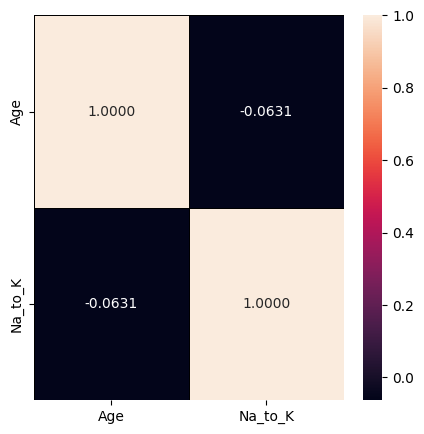

In [12]:
f, ax = plt.subplots(figsize = (5,5))
sns.heatmap(data.corr(numeric_only = True), annot = True, linewidths=0.5, linecolor = "black", fmt = ".4f", ax = ax)
plt.show()

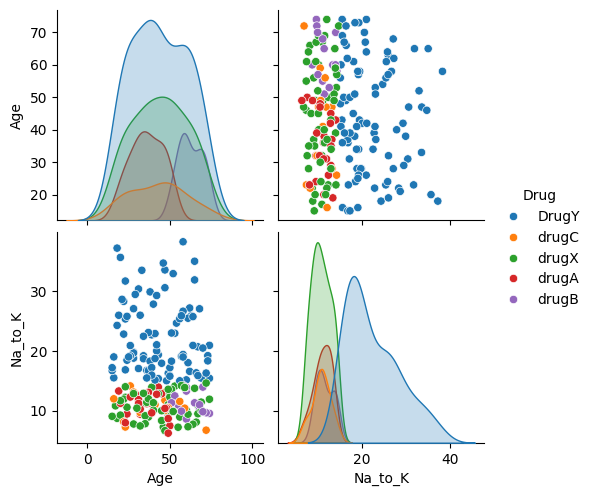

In [13]:
sns.pairplot(data, hue = "Drug")

In [14]:
data.columns

Index(['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K', 'Drug'], dtype='object')

In [15]:
data['Age'].value_counts(dropna=False)

,count
Age,
47,8
23,7
28,7
49,7
39,6
32,6
50,5
37,5
58,5


In [16]:
data['Sex'].value_counts()

,count
Sex,
M,104
F,96


In [17]:
data['BP'].value_counts()

,count
BP,
HIGH,77
LOW,64
NORMAL,59


In [19]:
data['Cholesterol'].value_counts()

,count
Cholesterol,
HIGH,103
NORMAL,97


In [20]:
data['Drug'].value_counts()

,count
Drug,
DrugY,91
drugX,54
drugA,23
drugC,16
drugB,16


[Data Visualization]

In [21]:
# number of age 로 데이터 시각화
dataAge = data["Age"].value_counts(dropna = False)
npar_dataAge = np.array(dataAge)
x = list(npar_dataAge)
y = data.Age.value_counts().index

DataAge = {"Age": y, "Number": x}
DataAge = pd.DataFrame(DataAge)

fig = px.bar(DataAge, x = "Age", y = "Number")
fig.show()

In [22]:
# Sex 시각화
colors = ['gold', 'mediumturquoise']

fig = go.Figure(data = [go.Pie(labels= ['M', 'F'], values=[104, 96])])

fig.update_traces(hoverinfo = 'label + percent', textinfo = 'value', textfont_size = 20,
                 marker = dict(colors = colors, line = dict( color = '#000000', width = 2)))

fig.show()


In [23]:
# Blood Pressure Levels 시각화
fig = px.bar(x = ["HIGH", "LOW", "NORMAL"], y = [77, 64, 59])

fig.show()

In [24]:
# cholesterol 시각화
fig = px.histogram(x = ["HIGH", "NORMAL"], y = [103, 97])
fig.show()

In [25]:
# Drug 시각화
fig = go.Figure(data = [go.Pie(labels=["DrugY","DrugX","DrugA","DrugC","DrugB"], values=[91,54,23,16,16])])

fig.update_traces(hoverinfo = 'label + percent', textinfo = 'value', textfont_size = 20,
                 marker = dict(colors = px.colors.sequential.RdBu, line = dict( color = '#000000', width = 2)))

fig.show()

In [26]:
# age/ Na_To_K(Na to Potassium Ratio) 관계 시각화
fig = px.scatter(data, x = "Na_to_K", y="Age", color="Drug",
                 size='Age', hover_data=['Na_to_K'])
fig.show()

[Data Preparing]

In [27]:
dataclass = pd.read_csv('drive/My Drive/Colab Notebooks/drug200.csv')

In [28]:
dataclass

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY
...,...,...,...,...,...,...
195,56,F,LOW,HIGH,11.567,drugC
196,16,M,LOW,HIGH,12.006,drugC
197,52,M,NORMAL,HIGH,9.894,drugX
198,23,M,NORMAL,NORMAL,14.020,drugX


In [29]:
dataclass.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


In [30]:
# Age type 변경 (F = 1/ M = 0)
dataclass.Sex = [1 if i == "F" else 0 for i in dataclass.Sex]

In [31]:
dataclass

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,1,HIGH,HIGH,25.355,DrugY
1,47,0,LOW,HIGH,13.093,drugC
2,47,0,LOW,HIGH,10.114,drugC
3,28,1,NORMAL,HIGH,7.798,drugX
4,61,1,LOW,HIGH,18.043,DrugY
...,...,...,...,...,...,...
195,56,1,LOW,HIGH,11.567,drugC
196,16,0,LOW,HIGH,12.006,drugC
197,52,0,NORMAL,HIGH,9.894,drugX
198,23,0,NORMAL,NORMAL,14.020,drugX


In [32]:
# Blood Pressure Levels(BP) type 변경
# Low = 2
# Normal = 1
# High = 0

import warnings
warnings.filterwarnings('ignore')

for i in range(0,len(dataclass.BP)):
    if dataclass.BP[i] == "LOW":
        dataclass.BP[i] = 2

    elif dataclass.BP[i] == "NORMAL":
        dataclass.BP[i] = 1

    else:
        dataclass.BP[i] = 0


In [33]:
dataclass

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,1,0,HIGH,25.355,DrugY
1,47,0,2,HIGH,13.093,drugC
2,47,0,2,HIGH,10.114,drugC
3,28,1,1,HIGH,7.798,drugX
4,61,1,2,HIGH,18.043,DrugY
...,...,...,...,...,...,...
195,56,1,2,HIGH,11.567,drugC
196,16,0,2,HIGH,12.006,drugC
197,52,0,1,HIGH,9.894,drugX
198,23,0,1,NORMAL,14.020,drugX


In [34]:
# Cholesterol type 변경
# High = 1
# Normal = 0

dataclass.Cholesterol = [1 if i == "HIGH" else 0 for i in dataclass.Cholesterol]

In [35]:
dataclass

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,1,0,1,25.355,DrugY
1,47,0,2,1,13.093,drugC
2,47,0,2,1,10.114,drugC
3,28,1,1,1,7.798,drugX
4,61,1,2,1,18.043,DrugY
...,...,...,...,...,...,...
195,56,1,2,1,11.567,drugC
196,16,0,2,1,12.006,drugC
197,52,0,1,1,9.894,drugX
198,23,0,1,0,14.020,drugX


In [36]:
# Drug type 변경
# DrugY = 4
# DrugX = 3
# DrugA = 2
# DrugC = 1
# DrugB = 0

import warnings
warnings.filterwarnings('ignore')

for i in range(0,len(dataclass)):
    if dataclass.Drug[i] == "DrugY":
        dataclass.Drug[i] = 4
    elif dataclass.Drug[i] == "drugX":
        dataclass.Drug[i] = 3
    elif dataclass.Drug[i] == "drugA":
        dataclass.Drug[i] = 2
    elif dataclass.Drug[i] == "drugC":
        dataclass.Drug[i] = 1
    else:
        dataclass.Drug[i] = 0

In [37]:
dataclass

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,1,0,1,25.355,4
1,47,0,2,1,13.093,1
2,47,0,2,1,10.114,1
3,28,1,1,1,7.798,3
4,61,1,2,1,18.043,4
...,...,...,...,...,...,...
195,56,1,2,1,11.567,1
196,16,0,2,1,12.006,1
197,52,0,1,1,9.894,3
198,23,0,1,0,14.020,3


In [38]:
dataclass.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    int64  
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    int64  
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(3), object(2)
memory usage: 9.5+ KB


In [39]:
data_types_dict = {'BP': int, "Drug": int}

dataclass = dataclass.astype(data_types_dict)

dataclass.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    int64  
 2   BP           200 non-null    int64  
 3   Cholesterol  200 non-null    int64  
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    int64  
dtypes: float64(1), int64(5)
memory usage: 9.5 KB


In [40]:
x_data = dataclass.drop(['Drug'], axis = 1)

y_data = dataclass.Drug.values

In [41]:
x_data

,Age,Sex,BP,Cholesterol,Na_to_K
0,23,1,0,1,25.355
1,47,0,2,1,13.093
2,47,0,2,1,10.114
3,28,1,1,1,7.798
4,61,1,2,1,18.043
...,...,...,...,...,...
195,56,1,2,1,11.567
196,16,0,2,1,12.006
197,52,0,1,1,9.894
198,23,0,1,0,14.020


In [42]:
y_data


array([4, 1, 1, 3, 4, 3, 4, 1, 4, 4, 1, 4, 4, 4, 3, 4, 3, 2, 1, 4, 4, 4,
       4, 4, 4, 4, 4, 3, 4, 4, 3, 0, 3, 4, 3, 3, 2, 3, 3, 3, 4, 0, 4, 3,
       3, 3, 2, 1, 4, 4, 4, 3, 4, 4, 0, 1, 0, 4, 3, 4, 4, 2, 4, 3, 0, 4,
       2, 3, 4, 4, 0, 4, 3, 4, 4, 4, 2, 4, 2, 3, 0, 3, 1, 2, 1, 0, 3, 4,
       4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 2, 2, 1, 3, 4, 3, 3, 4, 0, 4,
       2, 3, 3, 3, 3, 4, 3, 3, 2, 4, 4, 4, 4, 4, 0, 4, 4, 3, 4, 3, 4, 4,
       3, 4, 4, 3, 0, 2, 0, 3, 2, 4, 0, 4, 2, 3, 3, 2, 3, 1, 2, 0, 3, 3,
       4, 1, 2, 4, 1, 3, 3, 0, 3, 4, 4, 4, 4, 3, 4, 2, 3, 3, 4, 4, 2, 4,
       2, 4, 4, 4, 4, 3, 3, 4, 4, 4, 0, 2, 4, 4, 4, 2, 4, 1, 4, 1, 1, 3,
       3, 3])

In [43]:
# Train test split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=1)

[Decision Tree Classifier]

In [44]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

dtc = DecisionTreeClassifier()

# Fit the model
dtc.fit(x_train, y_train)

# Predict the x_test
predict = dtc.predict(x_test)

print('The accuracy of the Decision Tree is',metrics.accuracy_score(predict,y_test))

The accuracy of the Decision Tree is 0.9666666666666667


- Decision Tree Classifier with 'gini'

In [46]:
DTC_gini = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=0)

# Fit the model
DTC_gini.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=0)

In [47]:
y_pred_gini = DTC_gini.predict(x_test)

In [48]:
from sklearn.metrics import accuracy_score

print('Model accuracy score with criterion gini index: {0:0.4f}'. format(accuracy_score(y_test, y_pred_gini)))

Model accuracy score with criterion gini index: 0.9000


In [49]:
y_pred_train_gini = DTC_gini.predict(x_train)

y_pred_train_gini

array([3, 3, 2, 4, 2, 3, 3, 3, 4, 2, 0, 3, 4, 3, 4, 3, 4, 3, 4, 4, 4, 4,
       3, 4, 2, 4, 3, 3, 2, 3, 4, 2, 0, 0, 3, 3, 3, 3, 3, 4, 4, 4, 4, 3,
       3, 0, 0, 2, 4, 3, 4, 3, 4, 4, 3, 3, 4, 4, 2, 4, 4, 4, 2, 3, 4, 4,
       4, 3, 4, 3, 3, 2, 3, 2, 4, 4, 4, 4, 3, 4, 0, 3, 3, 4, 0, 4, 0, 4,
       4, 0, 4, 4, 2, 3, 4, 3, 2, 4, 3, 4, 4, 3, 4, 4, 4, 4, 4, 4, 3, 4,
       4, 2, 3, 3, 3, 4, 3, 4, 4, 4, 0, 4, 2, 3, 3, 2, 4, 4, 4, 4, 4, 3,
       2, 4, 3, 4, 2, 3, 2, 3])

In [50]:
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train_gini)))

Training-set accuracy score: 0.9143


In [51]:
print('Training set score: {:.4f}'.format(DTC_gini.score(x_train, y_train)))

print('Test set score: {:.4f}'.format(DTC_gini.score(x_test, y_test)))

Training set score: 0.9143
Test set score: 0.9000


- Decision Tree Classifier with 'entropy'

In [52]:
# criterion entropy 로 DecisionTreeClassifier model 초기화
DTC_en = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)


DTC_en.fit(x_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)

In [54]:
y_pred_en = DTC_en.predict(x_test)

In [55]:
print('Model accuracy score with criterion entropy: {0:0.4f}'. format(accuracy_score(y_test, y_pred_en)))

Model accuracy score with criterion entropy: 0.9000


In [56]:
y_pred_train_en = DTC_en.predict(x_train)

y_pred_train_en

array([3, 3, 2, 4, 2, 3, 3, 3, 4, 2, 0, 3, 4, 3, 4, 3, 4, 3, 4, 4, 4, 4,
       3, 4, 2, 4, 3, 3, 2, 3, 4, 2, 0, 0, 3, 3, 3, 3, 3, 4, 4, 4, 4, 3,
       3, 0, 0, 2, 4, 3, 4, 3, 4, 4, 3, 3, 4, 4, 2, 4, 4, 4, 2, 3, 4, 4,
       4, 3, 4, 3, 3, 2, 3, 2, 4, 4, 4, 4, 3, 4, 0, 3, 3, 4, 0, 4, 0, 4,
       4, 0, 4, 4, 2, 3, 4, 3, 2, 4, 3, 4, 4, 3, 4, 4, 4, 4, 4, 4, 3, 4,
       4, 2, 3, 3, 3, 4, 3, 4, 4, 4, 0, 4, 2, 3, 3, 2, 4, 4, 4, 4, 4, 3,
       2, 4, 3, 4, 2, 3, 2, 3])

In [57]:
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train_en)))

Training-set accuracy score: 0.9143


In [58]:
print('Training set score: {:.4f}'.format(DTC_en.score(x_train, y_train)))

print('Test set score: {:.4f}'.format(DTC_en.score(x_test, y_test)))

Training set score: 0.9143
Test set score: 0.9000


[Random Forest Classifier]

In [59]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state = 0)

# Fit the model
rfc.fit(x_train, y_train)

# Predict the model
predict = rfc.predict(x_test)

print('The accuracy of the Random Forest is',metrics.accuracy_score(predict,y_test))

The accuracy of the Random Forest is 0.95


- Random Forest Classifier with 'n_estimators=100'

In [60]:
from sklearn.ensemble import RandomForestClassifier

rfc_100 = RandomForestClassifier(n_estimators=100, random_state=0)

# Fit the model
rfc_100.fit(x_train, y_train)

# Predict the model
predict = rfc_100.predict(x_test)

print('The accuracy of the Random Forest is',metrics.accuracy_score(predict,y_test))

The accuracy of the Random Forest is 0.95


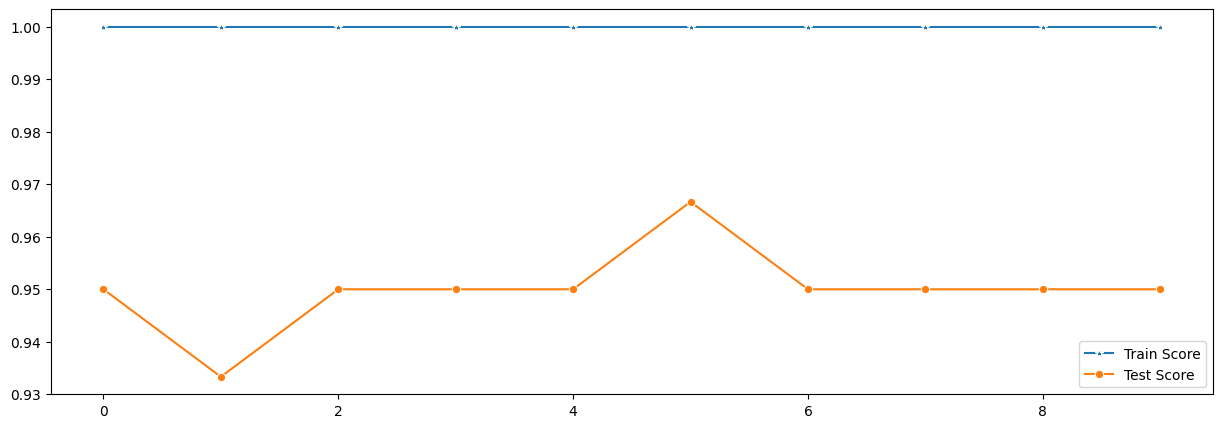

In [62]:
test_score_list = []
train_score_list = []

for i in range(0,10):
    rfc2 = RandomForestClassifier(random_state=i)
    rfc2.fit(x_train, y_train)
    test_score_list.append(rfc2.score(x_test, y_test))
    train_score_list.append(rfc2.score(x_train, y_train))

plt.figure(figsize=(15,5))
p = sns.lineplot(x=range(0, 10), y=train_score_list, marker='*', label='Train Score')
p = sns.lineplot(x=range(0, 10), y=test_score_list, marker='o', label='Test Score')

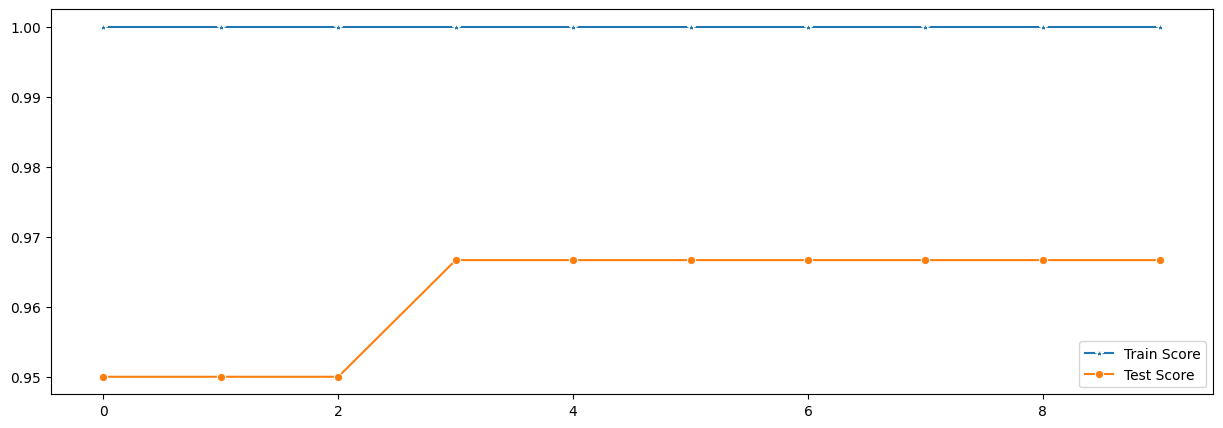

In [65]:
test_score_list = []
train_score_list = []

list_n_estimators = [10,20,30,40,50,60,70,80,90,100]


for i in range(0,len(list_n_estimators)):
    rfc3 = RandomForestClassifier(n_estimators=list_n_estimators[i], random_state=5)
    rfc3.fit(x_train, y_train)
    test_score_list.append(rfc3.score(x_test, y_test))
    train_score_list.append(rfc3.score(x_train, y_train))

plt.figure(figsize=(15,5))
p = sns.lineplot(x=range(0,len(list_n_estimators)),y=train_score_list,marker='*',label='Train Score')
p = sns.lineplot(x=range(0,len(list_n_estimators)),y=test_score_list,marker='o',label='Test Score')

- Random Forest Classifier With The Best Parameters

In [66]:
last_rfc = RandomForestClassifier(n_estimators=100, random_state=5)

# fit the model
last_rfc.fit(x_train,y_train)

predict = last_rfc.predict(x_test)

print('The accuracy of the Random Forest is',metrics.accuracy_score(predict,y_test))

The accuracy of the Random Forest is 0.9666666666666667


In [68]:
y_pred_en = last_rfc.predict(x_test)

In [70]:
print('Model accuracy score with best parameters: {0:0.4f}'. format(accuracy_score(y_test, y_pred_en)))

Model accuracy score with best parameters: 0.9667


In [71]:
y_pred_train_en = last_rfc.predict(x_train)

y_pred_train_en

array([3, 3, 2, 4, 2, 3, 3, 3, 4, 2, 0, 1, 4, 1, 4, 3, 4, 3, 4, 4, 4, 4,
       3, 4, 2, 4, 1, 3, 2, 3, 4, 2, 0, 0, 3, 3, 1, 3, 3, 4, 4, 4, 4, 3,
       1, 0, 0, 2, 4, 3, 4, 1, 4, 4, 1, 3, 4, 4, 2, 4, 4, 4, 2, 3, 4, 4,
       4, 3, 4, 1, 3, 2, 3, 2, 4, 4, 4, 4, 3, 4, 0, 3, 3, 4, 0, 4, 0, 4,
       4, 0, 4, 4, 2, 3, 4, 3, 2, 4, 1, 4, 4, 3, 4, 4, 4, 4, 4, 4, 1, 4,
       4, 2, 3, 1, 1, 4, 3, 4, 4, 4, 0, 4, 2, 3, 3, 2, 4, 4, 4, 4, 4, 3,
       2, 4, 3, 4, 2, 3, 2, 3])

In [72]:
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train_en)))

Training-set accuracy score: 1.0000


In [73]:
print('Training set score: {:.4f}'.format(last_rfc.score(x_train, y_train)))

print('Test set score: {:.4f}'.format(last_rfc.score(x_test, y_test)))

Training set score: 1.0000
Test set score: 0.9667


[Evaluation Classification Models]

- Confusion Matrix For DecisionTreeClassifier Without Parameters

In [74]:
# For Desicion Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

cm_des = DecisionTreeClassifier()

# fit the model
cm_des.fit(x_train,y_train)

y_pred_cm = cm_des.predict(x_test)
y_true = y_test

cm_des1 = confusion_matrix( y_true, y_pred_cm)
cm_des1

array([[ 4,  0,  2,  0,  0],
       [ 0,  4,  0,  0,  0],
       [ 0,  0,  4,  0,  0],
       [ 0,  0,  0, 19,  0],
       [ 0,  0,  0,  0, 27]])

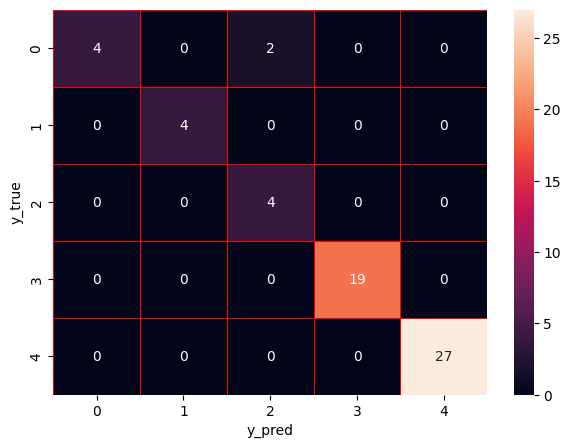

In [75]:
f, ax = plt.subplots(figsize = (7,5))
sns.heatmap(cm_des1, annot = True, linewidths=0.5, linecolor="red", fmt = ".0f", ax = ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

- Confusion Matrix For Decision Tree Classifier With 'gini'

In [76]:
cm_des_gini = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=0)

# fit the model
cm_des_gini.fit(x_train,y_train)

y_pred_cm = cm_des_gini.predict(x_test)
y_true = y_test

cm_des2 = confusion_matrix( y_true, y_pred_cm)
cm_des2

array([[ 4,  0,  2,  0,  0],
       [ 0,  0,  0,  4,  0],
       [ 0,  0,  4,  0,  0],
       [ 0,  0,  0, 19,  0],
       [ 0,  0,  0,  0, 27]])

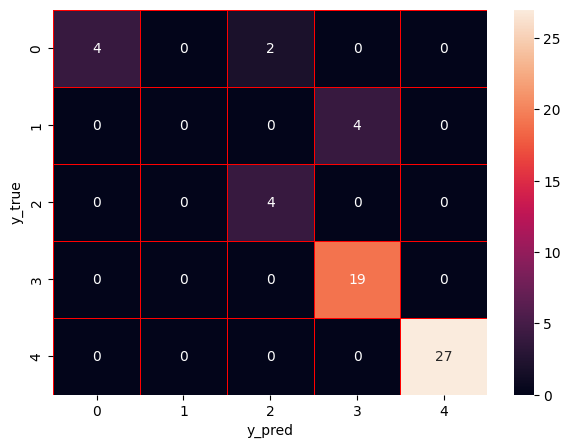

In [77]:
f, ax = plt.subplots(figsize = (7,5))
sns.heatmap(cm_des2, annot = True, linewidths=0.5, linecolor="red", fmt = ".0f", ax = ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

- Confusion Matrix For Random Forest Classifier With The Best Parameters

In [78]:
cm_last_rfc = RandomForestClassifier(n_estimators=100, random_state=5)

# Fit The Model
cm_last_rfc.fit(x_train, y_train)

y_pred_cm = cm_last_rfc.predict(x_test)
y_true = y_test

cm_rfc = confusion_matrix(y_true, y_pred_cm)
cm_rfc

array([[ 4,  0,  2,  0,  0],
       [ 0,  4,  0,  0,  0],
       [ 0,  0,  4,  0,  0],
       [ 0,  0,  0, 19,  0],
       [ 0,  0,  0,  0, 27]])

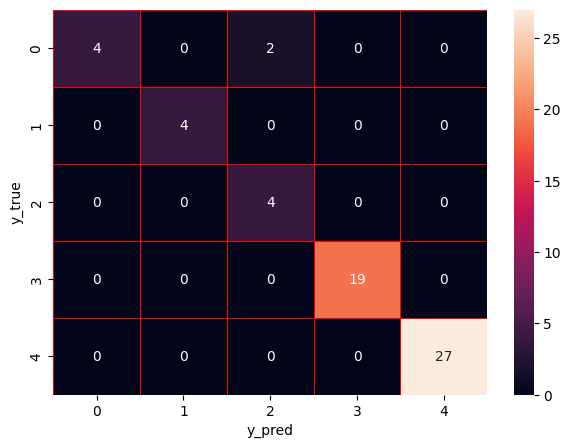

In [79]:
f, ax = plt.subplots(figsize = (7,5))
sns.heatmap(cm_rfc, annot = True, linewidths=0.5, linecolor="red", fmt = ".0f", ax = ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()